In [69]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [70]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [71]:
NUM_CLASSES = 26

# Dataset reading

In [72]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [73]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [76]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [78]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [79]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
123/128 [===========================>..] - ETA: 0s - loss: 3.2176 - accuracy: 0.0669
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 1s 5ms/step - loss: 3.2146 - accuracy: 0.0678 - val_loss: 3.0867 - val_accuracy: 0.1274
Epoch 2/1000
115/128 [=========================>....] - ETA: 0s - loss: 2.9989 - accuracy: 0.1086
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 0s 3ms/step - loss: 2.9860 - accuracy: 0.1089 - val_loss: 2.7742 - val_accuracy: 0.1331
Epoch 3/1000
108/128 [========================>.....] - ETA: 0s - loss: 2.7785 - accuracy: 0.1524
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
128/128 [==============================] - 0s 3ms/step - loss: 2.7652 - accuracy: 0.1550 - val_loss: 2.5116 - val_accuracy: 0.2594
Epoch 4/1000
110/128 [========================>.....] - ETA: 0s - loss: 2.6053 - accu

In [80]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 2ms/step - loss: 0.9496 - accuracy: 0.6853


In [81]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [82]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 40ms/step
[4.04487662e-02 2.07284756e-06 2.09270525e-04 1.88792372e-04
 1.23297488e-02 1.43849029e-05 3.24903976e-06 4.15307341e-06
 1.17638804e-01 1.15147752e-10 1.50586423e-08 2.27072887e-05
 6.51791766e-02 3.57300550e-01 2.44231371e-04 1.08599297e-05
 4.81928915e-08 6.00011444e-05 1.51522815e-01 2.51064986e-01
 4.82608069e-04 1.20221239e-06 9.54335405e-07 2.85863574e-03
 4.11943562e-04 2.63618194e-09]
13


# Confusion matrix

170/170 [==============================] - 0s 746us/step


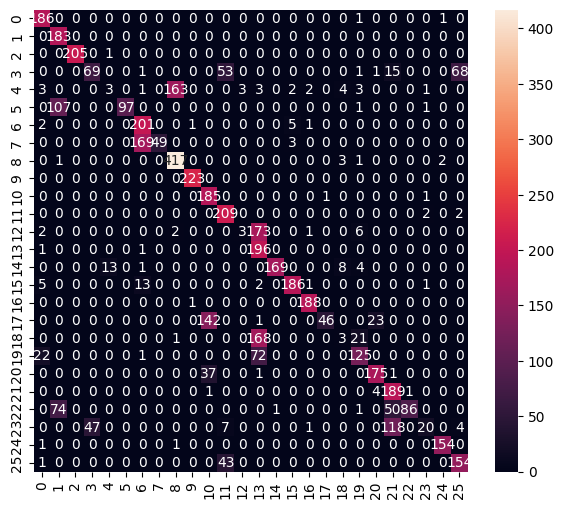

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       188
           1       0.50      1.00      0.67       183
           2       1.00      1.00      1.00       206
           3       0.59      0.33      0.43       208
           4       0.18      0.02      0.03       188
           5       1.00      0.47      0.64       206
           6       0.52      0.96      0.67       210
           7       1.00      0.22      0.36       221
           8       0.71      0.98      0.83       424
           9       0.99      1.00      1.00       223
          10       0.51      0.99      0.67       187
          11       0.67      0.98      0.80       213
          12       0.50      0.02      0.03       187
          13       0.32      0.99      0.48       198
          14       0.99      0.87      0.93       195
          15       0.95      0.89      0.92       208
          16       0.97      0.99      0.98       189
     

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [84]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [85]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpt3qp5wrs\assets


INFO:tensorflow:Assets written to: C:\Users\BIGDIP~1\AppData\Local\Temp\tmpt3qp5wrs\assets


TypeError: Builder.EndVector() missing 1 required positional argument: 'vectorNumElems'

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 131 µs, sys: 17 µs, total: 148 µs
Wall time: 679 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8105639e-01 1.8674169e-02 2.2328216e-04 4.6191799e-05]
0
